In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
tar_path = '/content/drive/MyDrive/segmentation-project/neurite-oasis.v1.0.tar'
extract_path = '/content/segmentation_data'
os.makedirs(extract_path, exist_ok=True)

# Extract if needed
!tar -xf "{tar_path}" -C "{extract_path}"

In [ ]:
!pip install nibabel matplotlib torch torchvision

In [ ]:
# Overwrite seg4_paths.txt with updated correct paths
with open("seg4_paths_copy.txt", "r") as f:
    lines = f.readlines()

with open("seg4_paths_copy.txt", "w") as f:
    for line in lines:
        updated = line.replace("neurite-oasis.v1.0", "segmentation_data")
        f.write(updated)

print("✅ Done! seg4_paths_copy.txt now uses 'segmentation_data'.")

✅ Done! seg4_paths_copy.txt now uses 'segmentation_data'.


In [ ]:
!python convert_one_hot.py --txt_path seg4_paths_copy.txt

Processing segmentation maps: 100% 414/414 [04:07<00:00,  1.68it/s]


In [ ]:
import os

# Check if one-hot file exists for first subject
print("Sample file:", os.listdir("segmentation_data/OASIS_OAS1_0395_MR1"))

Sample file: ['aligned_orig.nii.gz', 'slice_orig.nii.gz', 'seg4.nii.gz', 'aligned_seg35.nii.gz', 'seg35.nii.gz', 'orig.nii.gz', 'aligned_seg4.nii.gz', 'slice_seg24.nii.gz', 'norm.nii.gz', 'slice_seg4.nii.gz', 'aligned_norm.nii.gz', 'seg4_onehot.npy', 'slice_norm.nii.gz']


In [ ]:
!python train.py --train_txt /content/drive/MyDrive/segmentation-project/train_split.txt --template_path segmentation_data/OASIS_OAS1_0016_MR1/seg4_onehot.npy --batch_size 1 --epochs 50

Streaming output truncated to the last 5000 lines.
Cross-entropy: 0.929514
Training for epoch: 44/50:  71% 278/394 [02:47<01:09,  1.67it/s]Dice Loss: 0.1289
Cross-entropy: 0.919971
Training for epoch: 44/50:  71% 279/394 [02:47<01:08,  1.67it/s]Dice Loss: 0.1534
Cross-entropy: 0.924830
Training for epoch: 44/50:  71% 280/394 [02:48<01:08,  1.66it/s]Dice Loss: 0.1569
Cross-entropy: 0.925128
Training for epoch: 44/50:  71% 281/394 [02:48<01:08,  1.65it/s]Dice Loss: 0.1345
Cross-entropy: 0.922966
Training for epoch: 44/50:  72% 282/394 [02:49<01:07,  1.65it/s]Dice Loss: 0.1219
Cross-entropy: 0.921288
Training for epoch: 44/50:  72% 283/394 [02:50<01:07,  1.65it/s]Dice Loss: 0.1294
Cross-entropy: 0.918741
Training for epoch: 44/50:  72% 284/394 [02:50<01:06,  1.66it/s]Dice Loss: 0.1850
Cross-entropy: 0.927900
Training for epoch: 44/50:  72% 285/394 [02:51<01:05,  1.66it/s]Dice Loss: 0.1407
Cross-entropy: 0.921450
Training for epoch: 44/50:  73% 286/394 [02:51<01:04,  1.67it/s]Dice Loss: 0.

In [ ]:
from get_data import SegDataset
from model import UNet, SpatialTransformer
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_txt_path = '/content/drive/MyDrive/segmentation-project/train_split.txt'
template_path = 'segmentation_data/OASIS_OAS1_0016_MR1/seg4_onehot.npy'
model_path = 'checkpoints/original_unet_model.pth'

# Re-create dataset and dataloader
train_dataset = SegDataset(train_txt_path, template_path)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)

# Re-create your baseline model (UNet + SpatialTransformer)
model = UNet(in_channels=10, out_channels=3).to(device)
stn = SpatialTransformer(size=(128,128,128), device=device).to(device)

# Load the trained model
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
stn.load_state_dict(checkpoint['stn_state_dict'])
model.eval()
stn.eval()

print("Models loaded successfully!")

Models loaded successfully!


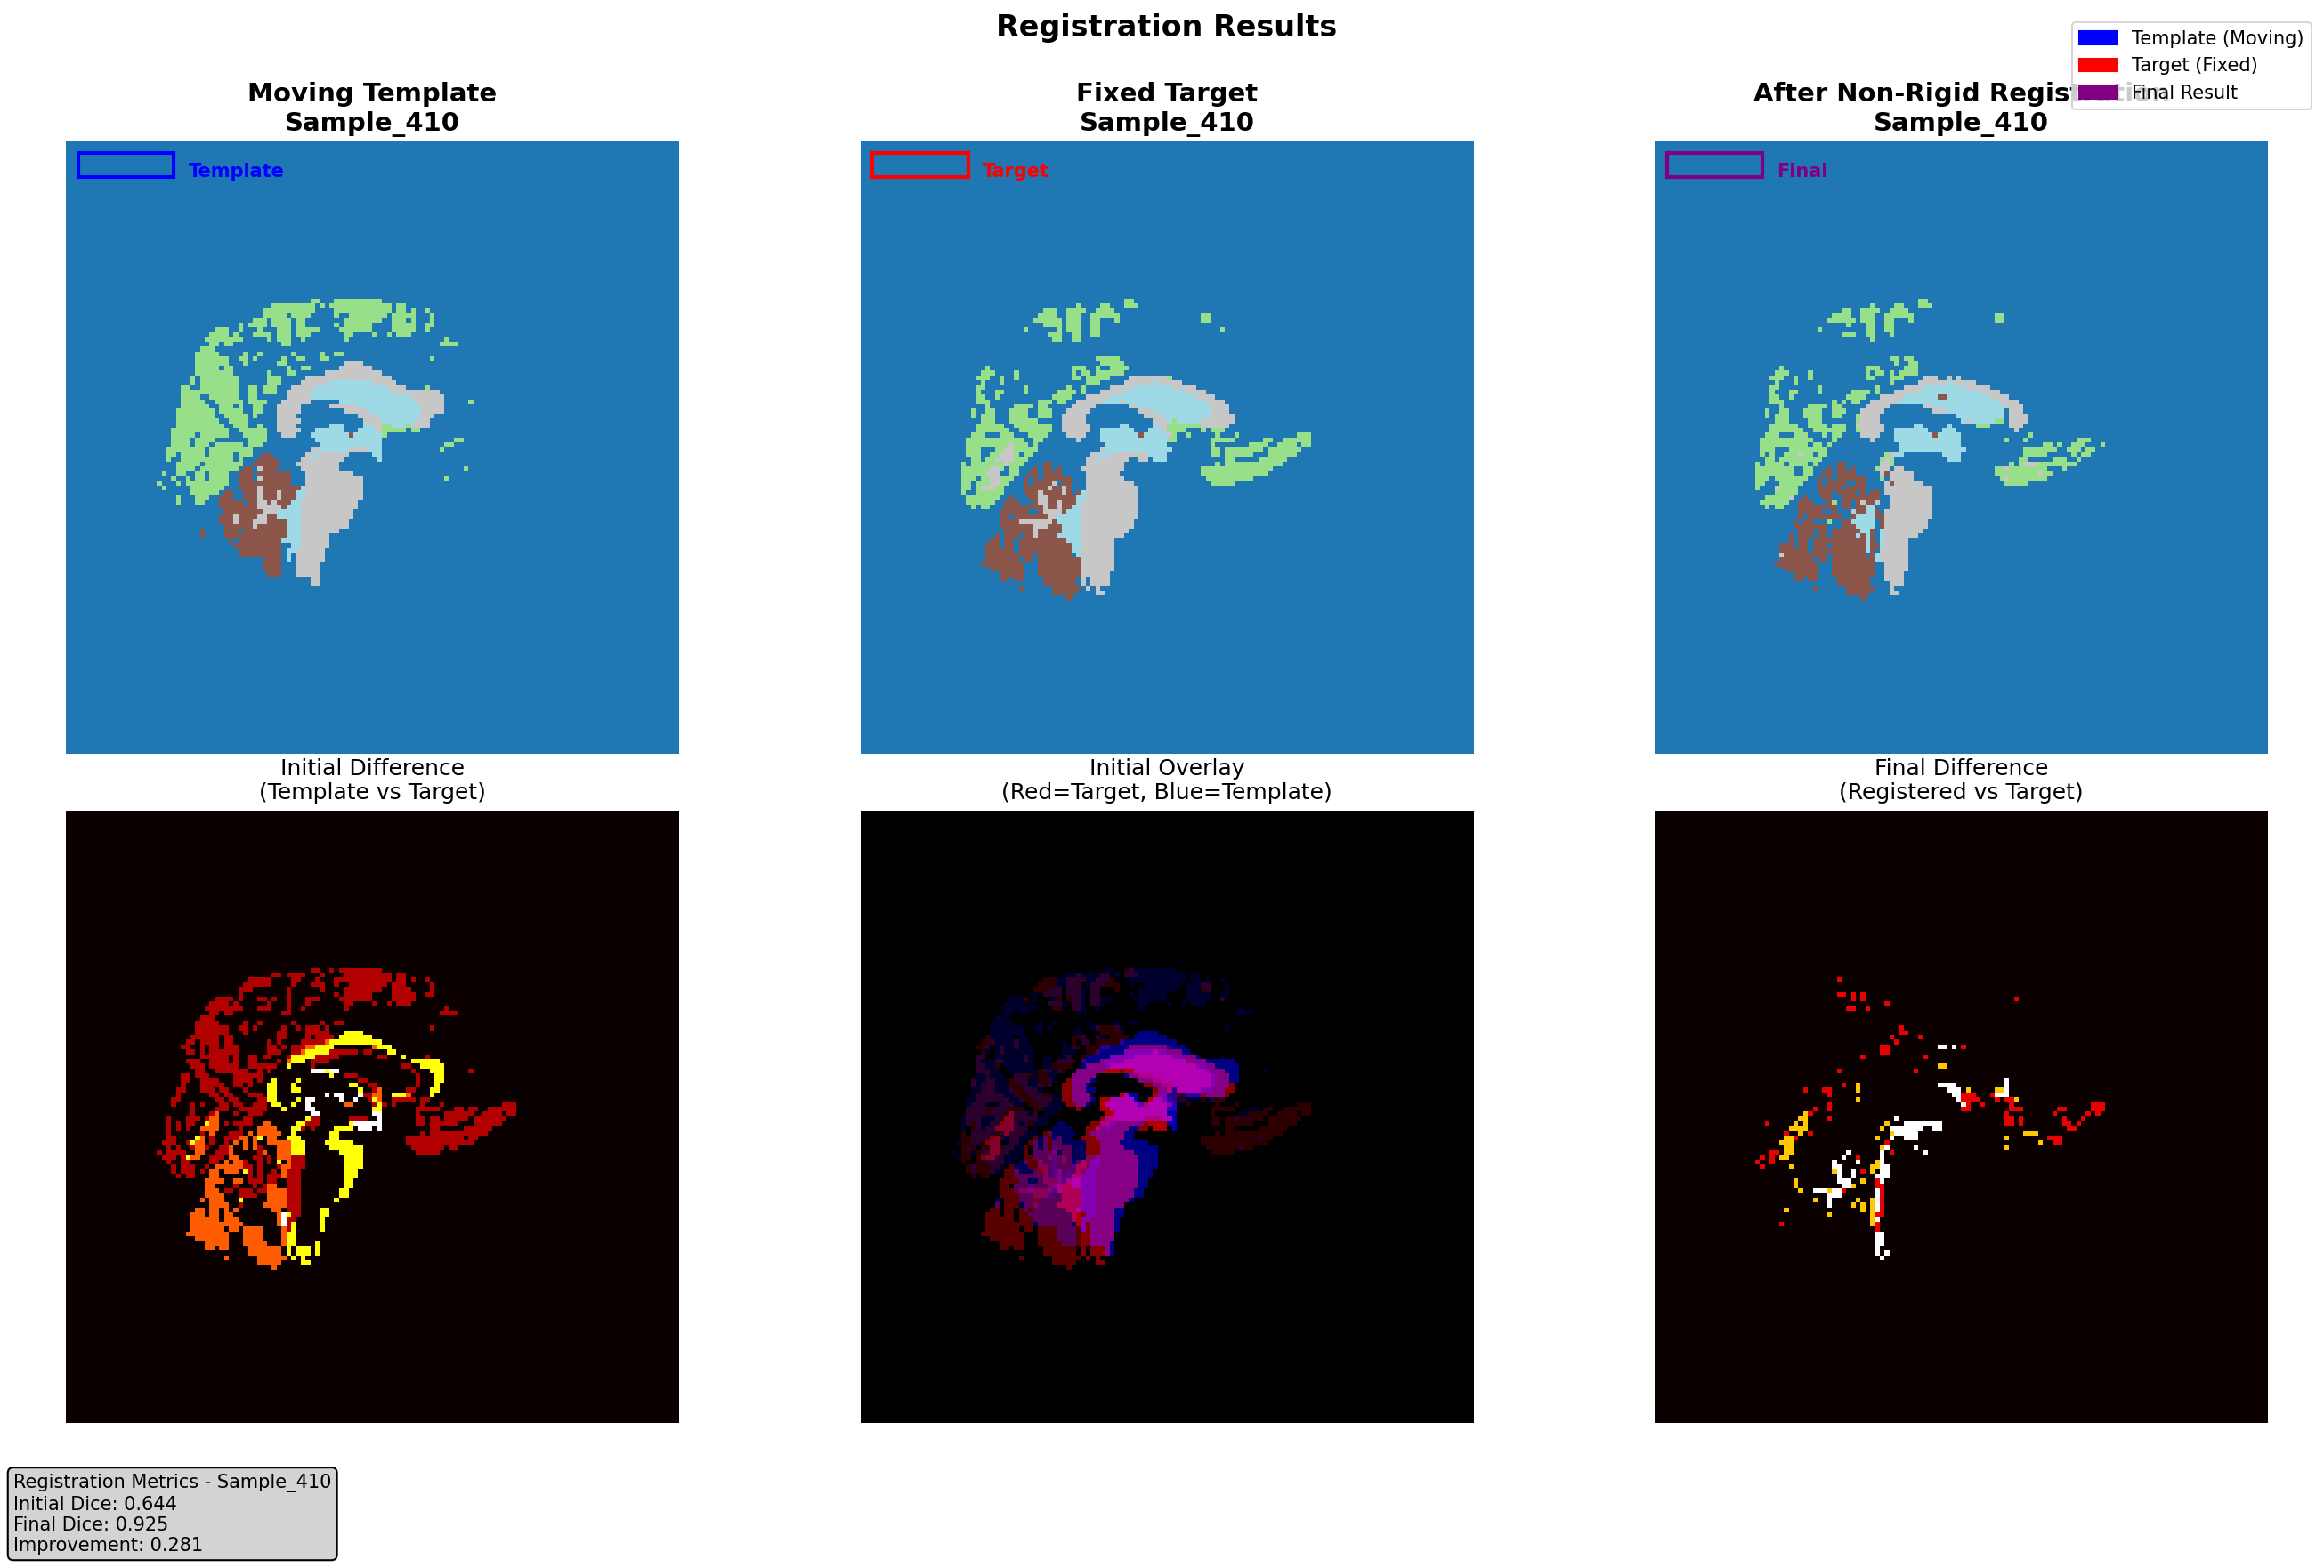

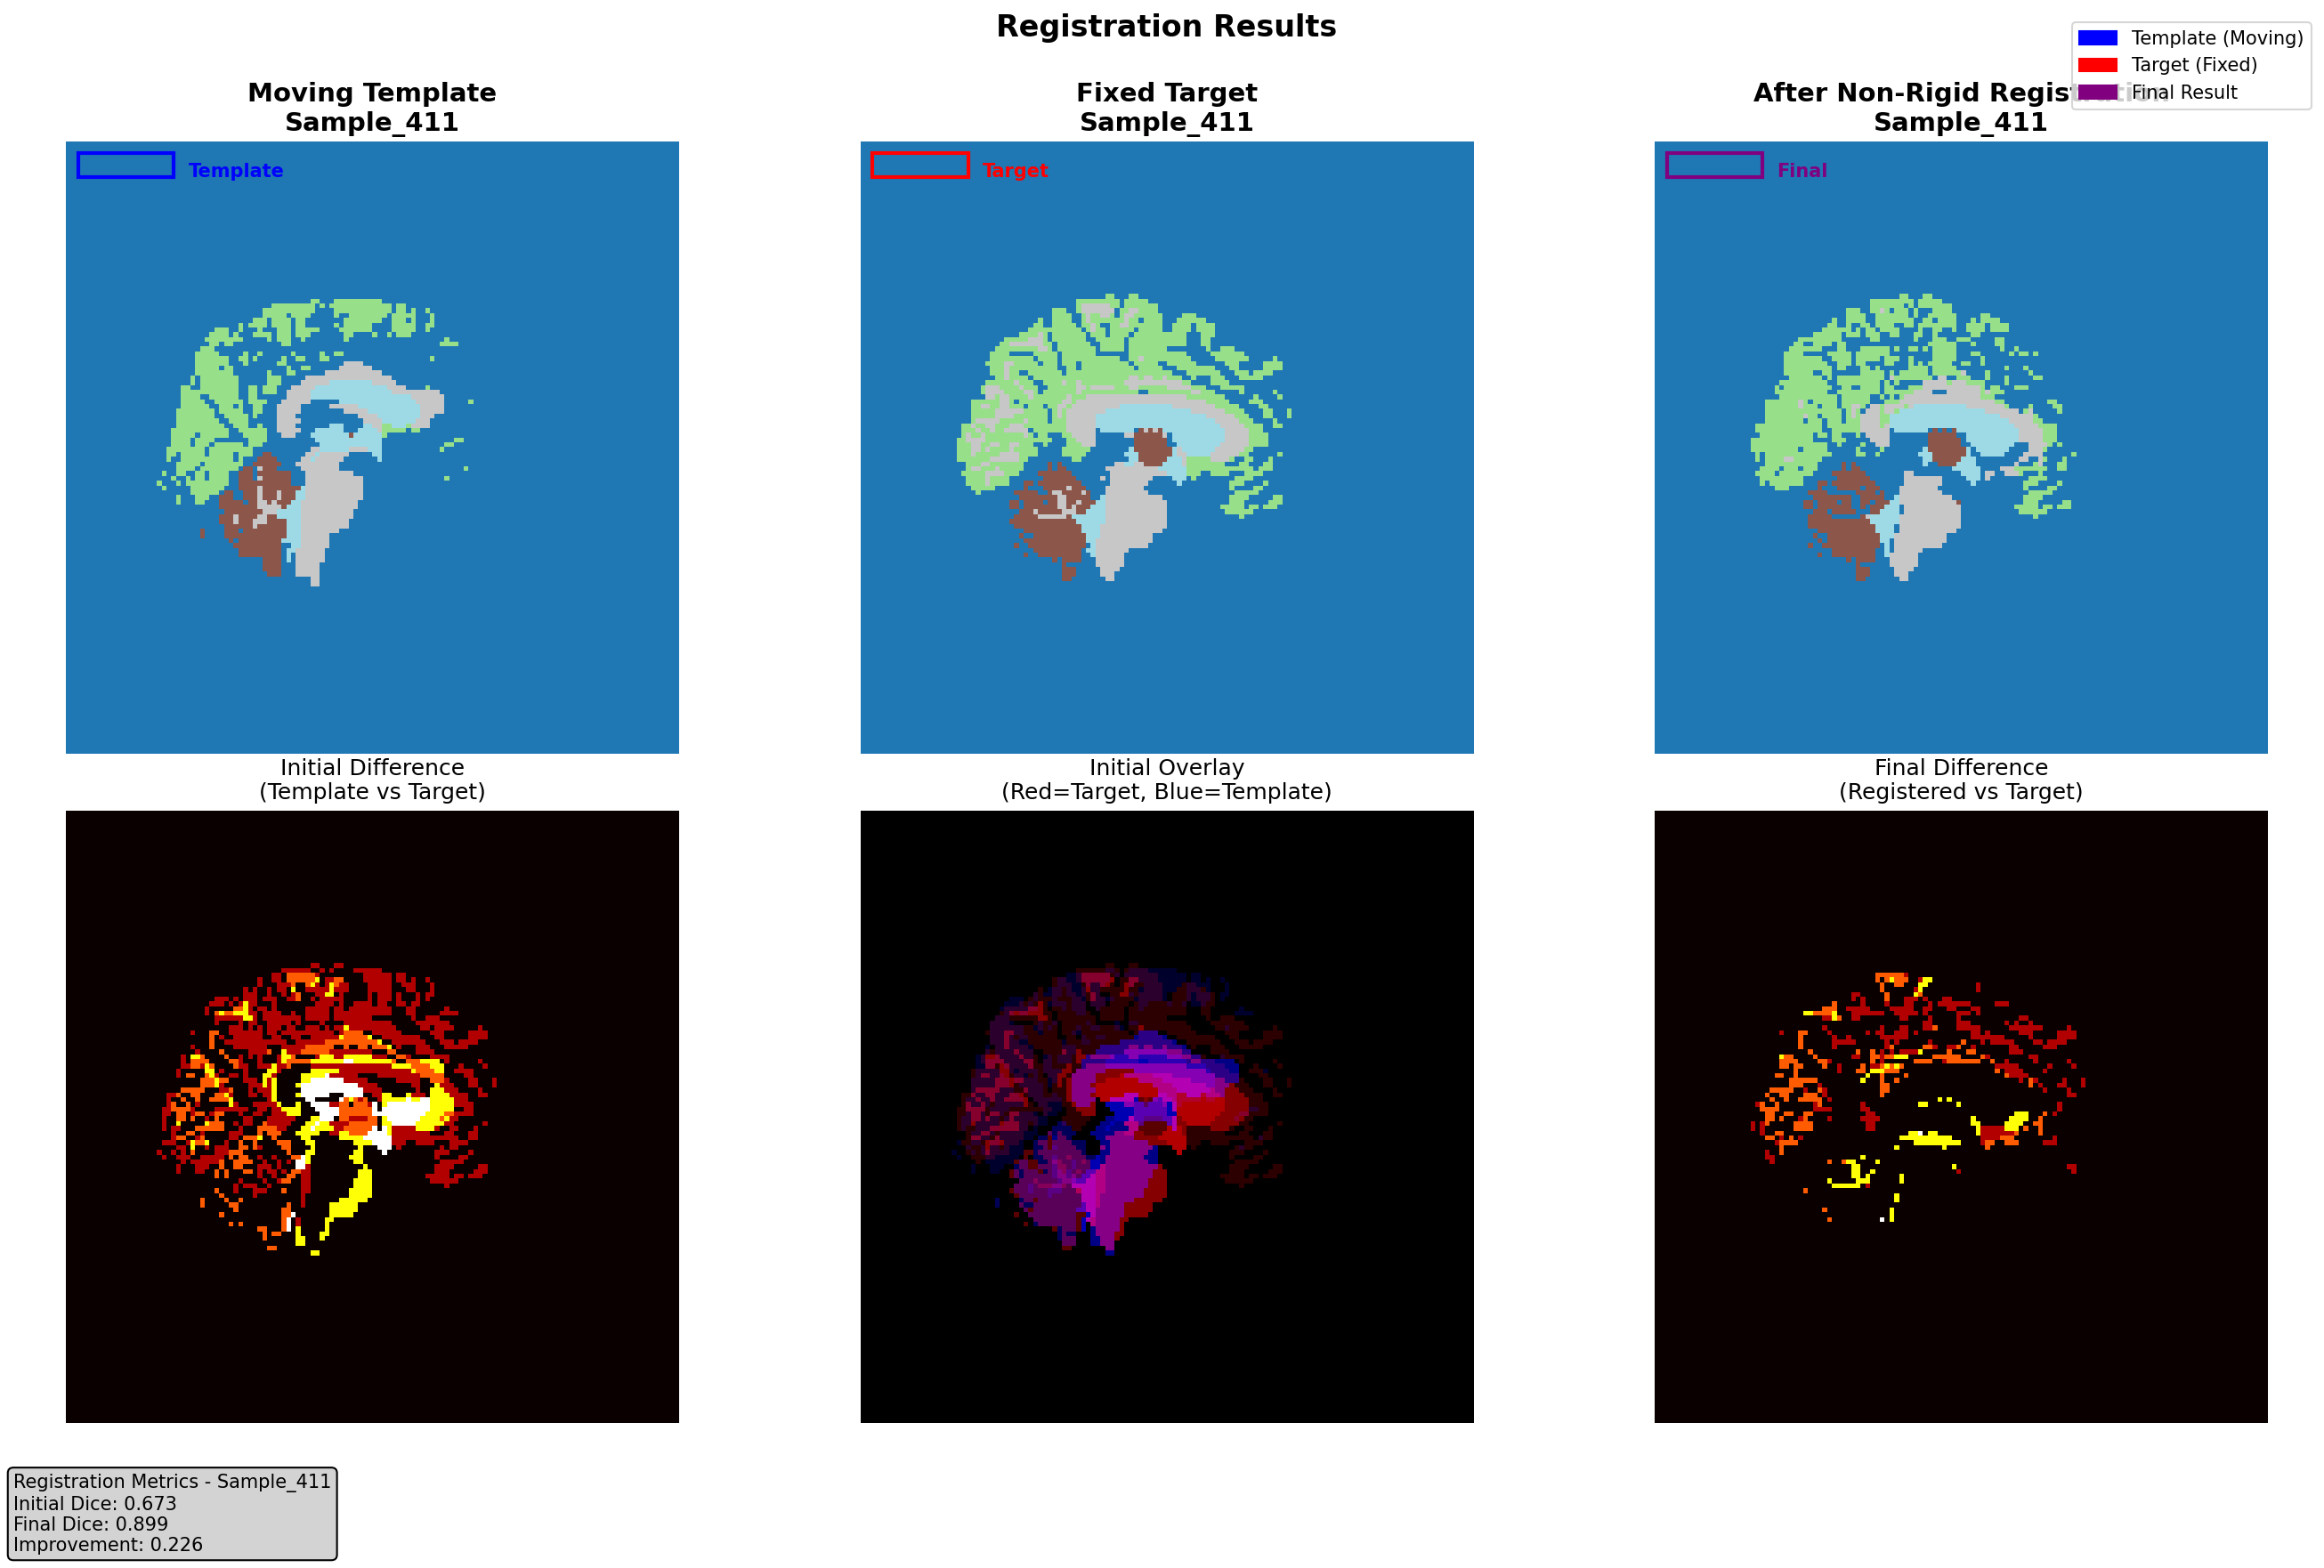

In [ ]:
# Correct way to use your baseline model
sample_batch = next(iter(train_loader))
moving, fixed = sample_batch
moving = moving.to(device)
fixed = fixed.to(device)

with torch.no_grad():
    # Your baseline model workflow:
    # 1. Concatenate moving and fixed as input to UNet
    input_ = torch.cat([moving, fixed], dim=1)  # Shape: (B, 10, 128, 128, 128)

    # 2. Get deformation field from UNet
    deformation_field = model(input_)

    # 3. Apply deformation using SpatialTransformer
    warped_template = stn(moving, deformation_field)

# Now use the correct visualization function (without affine components)
from visualize import visualize_registration_colab
visualize_registration_colab(moving, fixed, warped_template)

In [ ]:
# saving the model

!cp checkpoints/original_unet_model.pth /content/drive/MyDrive/segmentation-project/